In [1]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import tensorflow as tf
# noinspection PyInterpreter
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils

sns.set_theme()

print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nico/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nico/anaconda3/envs/tensorflow/lib

GPUs für die Berechnung: 0


In [2]:
#Metadaten einlesen
df = pd.read_csv("NIHMS841832-supplement-1.csv")

#Ergebnisse des Feature Tables einlesen
feature = pd.read_csv('feature_table.txt', sep='\t').T
feature = feature[1:][:-1]

In [3]:
#Gesunde Kontrollgruppe
HC = df[df.ibd_subtype.eq("HC")]

y = []
for row in feature.index:
    if any(True for val in HC['sample_name'] if val == row):
        y.append(1)
    else:
        y.append(0)

X = feature.iloc[:, :].values

In [4]:
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
1629.SubjectIBD335,0.0,345.0,0.0,0.0,0.0,0.0,412.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,353.0
1629.SubjectIBD643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1629.SubjectIBD539,0.0,2869.0,0.0,0.0,0.0,0.0,1665.0,0.0,0.0,0.0,...,0.0,746.0,0.0,0.0,0.0,3.0,21.0,0.0,0.0,88919.0
1629.SubjectIBD078,0.0,5.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1629.SubjectIBD671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Best Validation Loss: 1.4242
Best Validation Accuracy: 90.441%


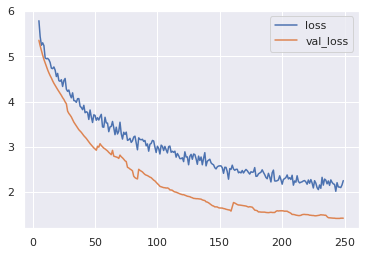

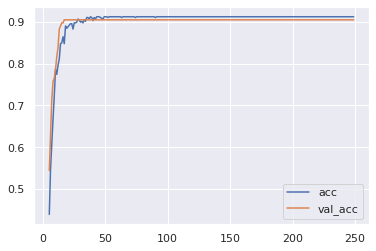

In [8]:
#Split Test und Trainingsdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Outcome als kategorische Variable speichern
# y_train = utils.to_categorical(y_train)
# y_test = utils.to_categorical(y_test)

# Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True
)

# Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
network = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(rate=0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(X_train.shape[0], activation='relu'),
])

network.compile(
    optimizer='adamax',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = network.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=250,
    callbacks=[early_stopping],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['acc', 'val_acc']].plot()
print(("Best Validation Loss: {:0.4f}" +
      "\nBest Validation Accuracy: {:0.3f}%")
      .format(history_df['val_loss'].min(), history_df['val_acc'].max()*100))

In [6]:
pred_test= network.predict(X_test)
scores_test = network.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test data: {np.round(scores_test[1]*100, 3)}% \nError on test data: {np.round((1 - scores_test[1])*100, 3)}%')


Accuracy on test data: 90.441% 
Error on test data: 9.559%
